In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
from scipy import stats
import os, errno
from hmmlearn.hmm import GaussianHMM
import seaborn as sns

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
ticker=["XLY", "XLP", "XLE", "XLF", "XLV", "XLI", "XLB", "XLK", "XLU"]
names= ["Consumer Disc", "Consumer Staples", "Energy", "Financials","Health","Industrials","Materials","Technology","Utilities"]
price_data=pd.DataFrame()
for i, tick in enumerate(ticker):
    price_data[ticker[i]]=  pd.read_excel(ticker[i]+".xlsx",skiprows=6)['PX_LAST']
price_data['Date']=pd.read_excel("XLY"+".xlsx",skiprows=6)['Date']
price_data['Date']=pd.to_datetime(price_data['Date'])
price_data=price_data.set_index('Date')
price_data=price_data.iloc[::-1]
return_data=(np.log(price_data)-np.log(price_data.shift(1))).dropna()
return_training=return_data[:'2018-12-31']

In [6]:
return_training.describe()

,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLK,XLU
count,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000,3523.000000
mean,0.000293,0.000224,0.000130,-0.000011,0.000299,0.000207,0.000151,0.000306,0.000182
std,0.013048,0.008355,0.017889,0.019759,0.010230,0.012896,0.014987,0.012541,0.010951
min,-0.123580,-0.062132,-0.155997,-0.182316,-0.102948,-0.098771,-0.132527,-0.090514,-0.077310
25%,-0.005224,-0.003954,-0.007858,-0.006604,-0.004343,-0.005249,-0.006604,-0.005010,-0.005118
50%,0.000771,0.000582,0.000625,0.000409,0.000571,0.000781,0.000825,0.000876,0.000815
75%,0.006499,0.004821,0.009319,0.007124,0.005737,0.006355,0.008035,0.006277,0.006001
max,0.093265,0.066590,0.152504,0.151874,0.113817,0.101700,0.131534,0.130136,0.113980


In [17]:
FF = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', skiprows=range(4)
                     , index_col=0, engine='python')
FF.index=FF.index.map(str)
FF_training=FF['20050103':'20181231']
VIX=  pd.read_excel('VIX'+".xlsx",skiprows=6)
VIX.loc[:, 'Date']=pd.to_datetime(VIX['Date'])
VIX=VIX.set_index('Date')
VIX=VIX.iloc[::-1]['PX_LAST']
VIX_return=(np.log(VIX)-np.log(VIX.shift(1))).dropna()

FF_training['VIX']=VIX_return[:'2018-12-31']

C:\Users\ANSHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [18]:
FF_training.corr()

,Mkt-RF,SMB,HML,RF,VIX
Mkt-RF,1.000000,0.174466,0.331413,-0.015954,-0.744661
SMB,0.174466,1.000000,-0.095419,-0.012999,-0.153708
HML,0.331413,-0.095419,1.000000,0.006939,-0.139870
RF,-0.015954,-0.012999,0.006939,1.000000,0.011068
VIX,-0.744661,-0.153708,-0.139870,0.011068,1.000000


In [19]:
regimes=[]
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
for i, tick in enumerate(ticker):
    regimes.append(MarkovRegression(return_training[tick], k_regimes=2, exog=FF_training[['Mkt-RF','SMB','HML','VIX']],switching_variance=True,trend='c').fit(em_iter=20))

C:\Users\ANSHUL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ANSHUL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ANSHUL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ANSHUL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and s

In [7]:
return_test=return_data['2019-01-02':'2020-06-30']
FF_test=FF['20190102':]
FF_test['VIX']=VIX_return['2019-01-02':'2020-06-30']

mod_hamilton_test=[]
for i, tick in enumerate(ticker):
    mod_hamilton_test.append(MarkovRegression(return_test[tick],exog=FF_test[['Mkt-RF','SMB','HML','VIX']], k_regimes=2,switching_variance=True,trend='c'))

C:\Users\ANSHUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ANSHUL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ANSHUL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\ANSHUL

In [29]:
regimes[0].params[0:2]

p[0->0]    0.988675
p[1->0]    0.002306
dtype: float64

In [33]:
df=pd.DataFrame(columns = ['ETF', 'p[0->0]', 'p[1->0]'])
for i,tick in enumerate(ticker):
    df=df.append({'ETF' : tick, 'p[0->0]' : regimes[i].params[0], 'p[1->0]' :  regimes[i].params[1]},  
                ignore_index = True)
df

,ETF,p[0->0],p[1->0]
0,XLY,0.988675,0.002306
1,XLP,0.993628,0.024777
2,XLE,0.995375,0.008800
3,XLF,0.996693,0.018305
4,XLV,0.949363,0.013755
5,XLI,0.961355,0.006094
6,XLB,0.994401,0.030416
7,XLK,0.986086,0.073025
8,XLU,0.984559,0.028288


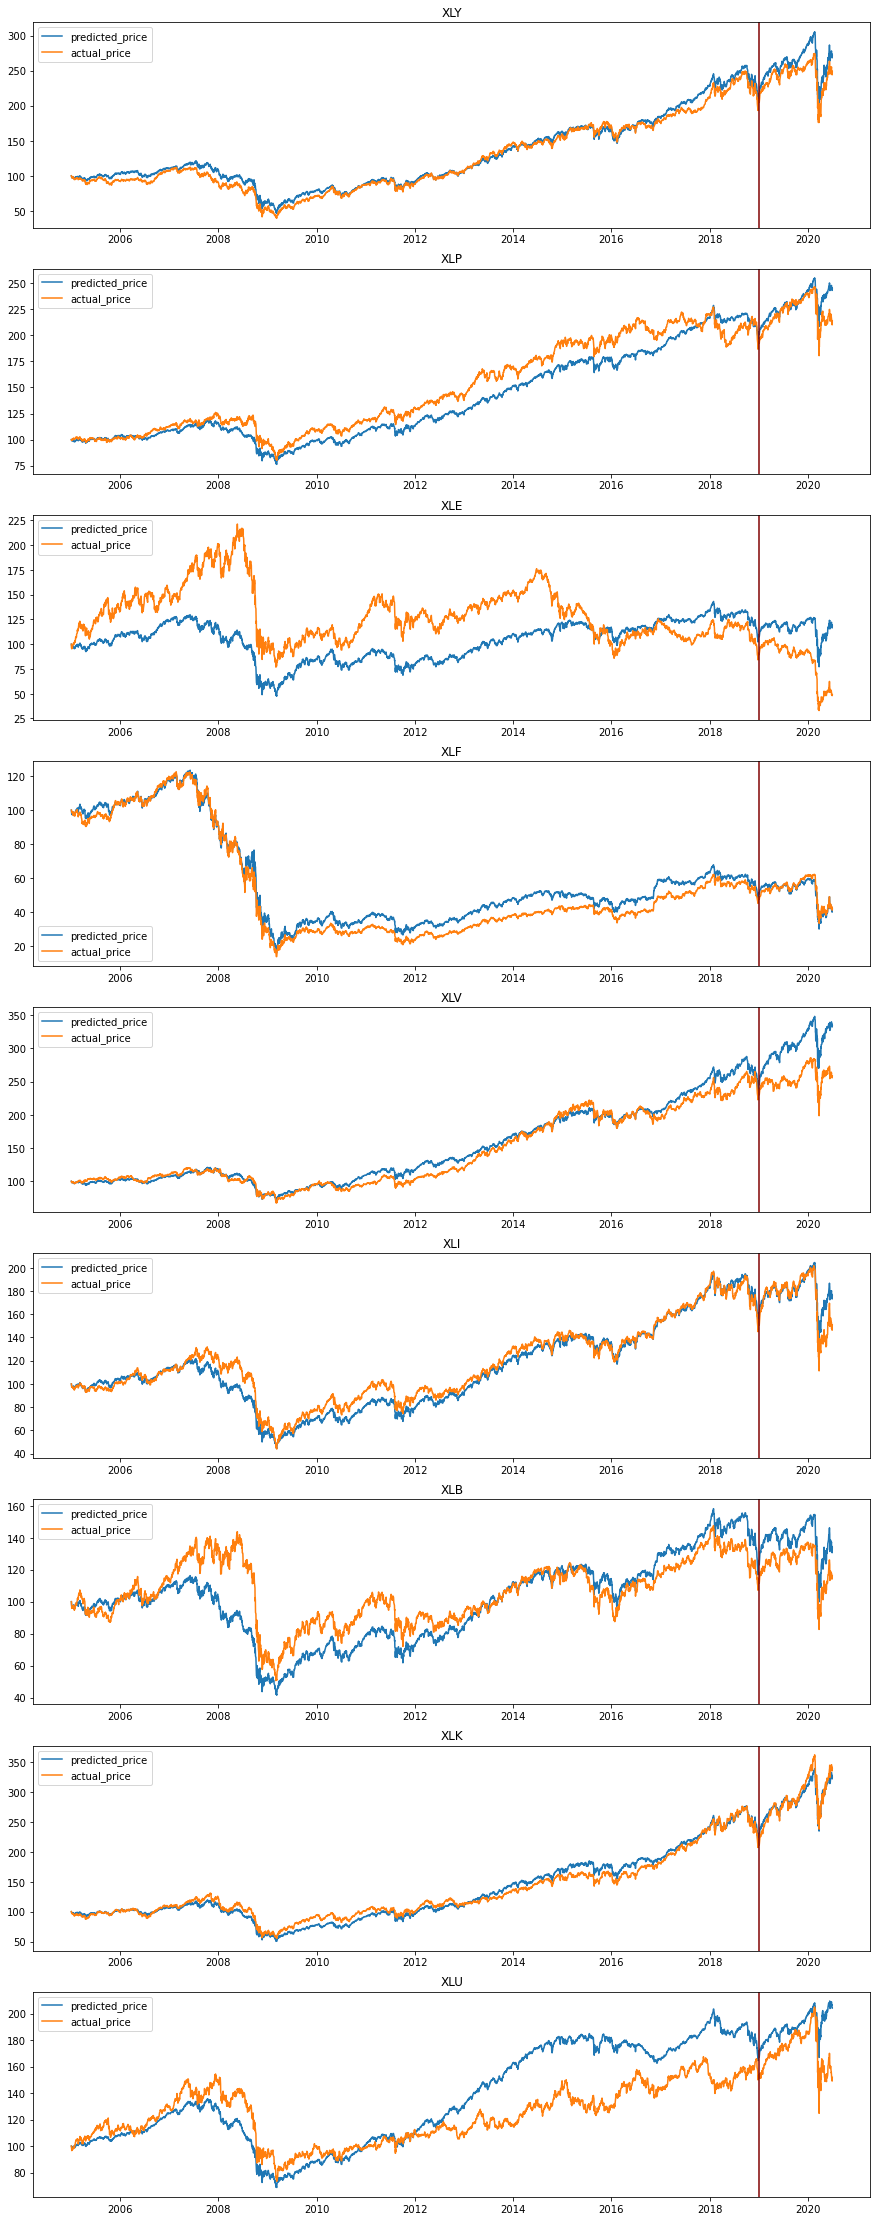

In [8]:
figure, axs = plt.subplots(9, figsize = (15, 40))
for i, tick in enumerate(ticker):

    predicted_ret=np.array(regimes[i].predict())                      
    actual_ret=np.array(return_data[tick][:'2020-06-30'])
    
    predicted_ret=np.append(predicted_ret,mod_hamilton_test[i].filter(regimes[i].params).predict())
    
    
    predicted_price=np.zeros(len(predicted_ret))
    actual_price=np.zeros(len(predicted_ret))
    predicted_price[0]=100
    actual_price[0]=100


    for j in range (1,len(predicted_ret)):
        predicted_price[j]=predicted_price[j-1]*(1+predicted_ret[j-1])
        actual_price[j]=actual_price[j-1]*(1+actual_ret[j-1])
    
    df=pd.DataFrame()
    df['predicted_price']=predicted_price
    df['actual_price']=actual_price
    df.index=return_data[:'2020-06-30'].index
    
    axs[i].plot(df)
    label=['predicted_price','actual_price']    
    axs[i].legend(label)    
    #axs[i].plot(actual_price)
    axs[i].set_title(tick)
    axs[i].axvline(return_data.index[return_training.shape[0]], color = "maroon")


<Figure size 1440x720 with 0 Axes>

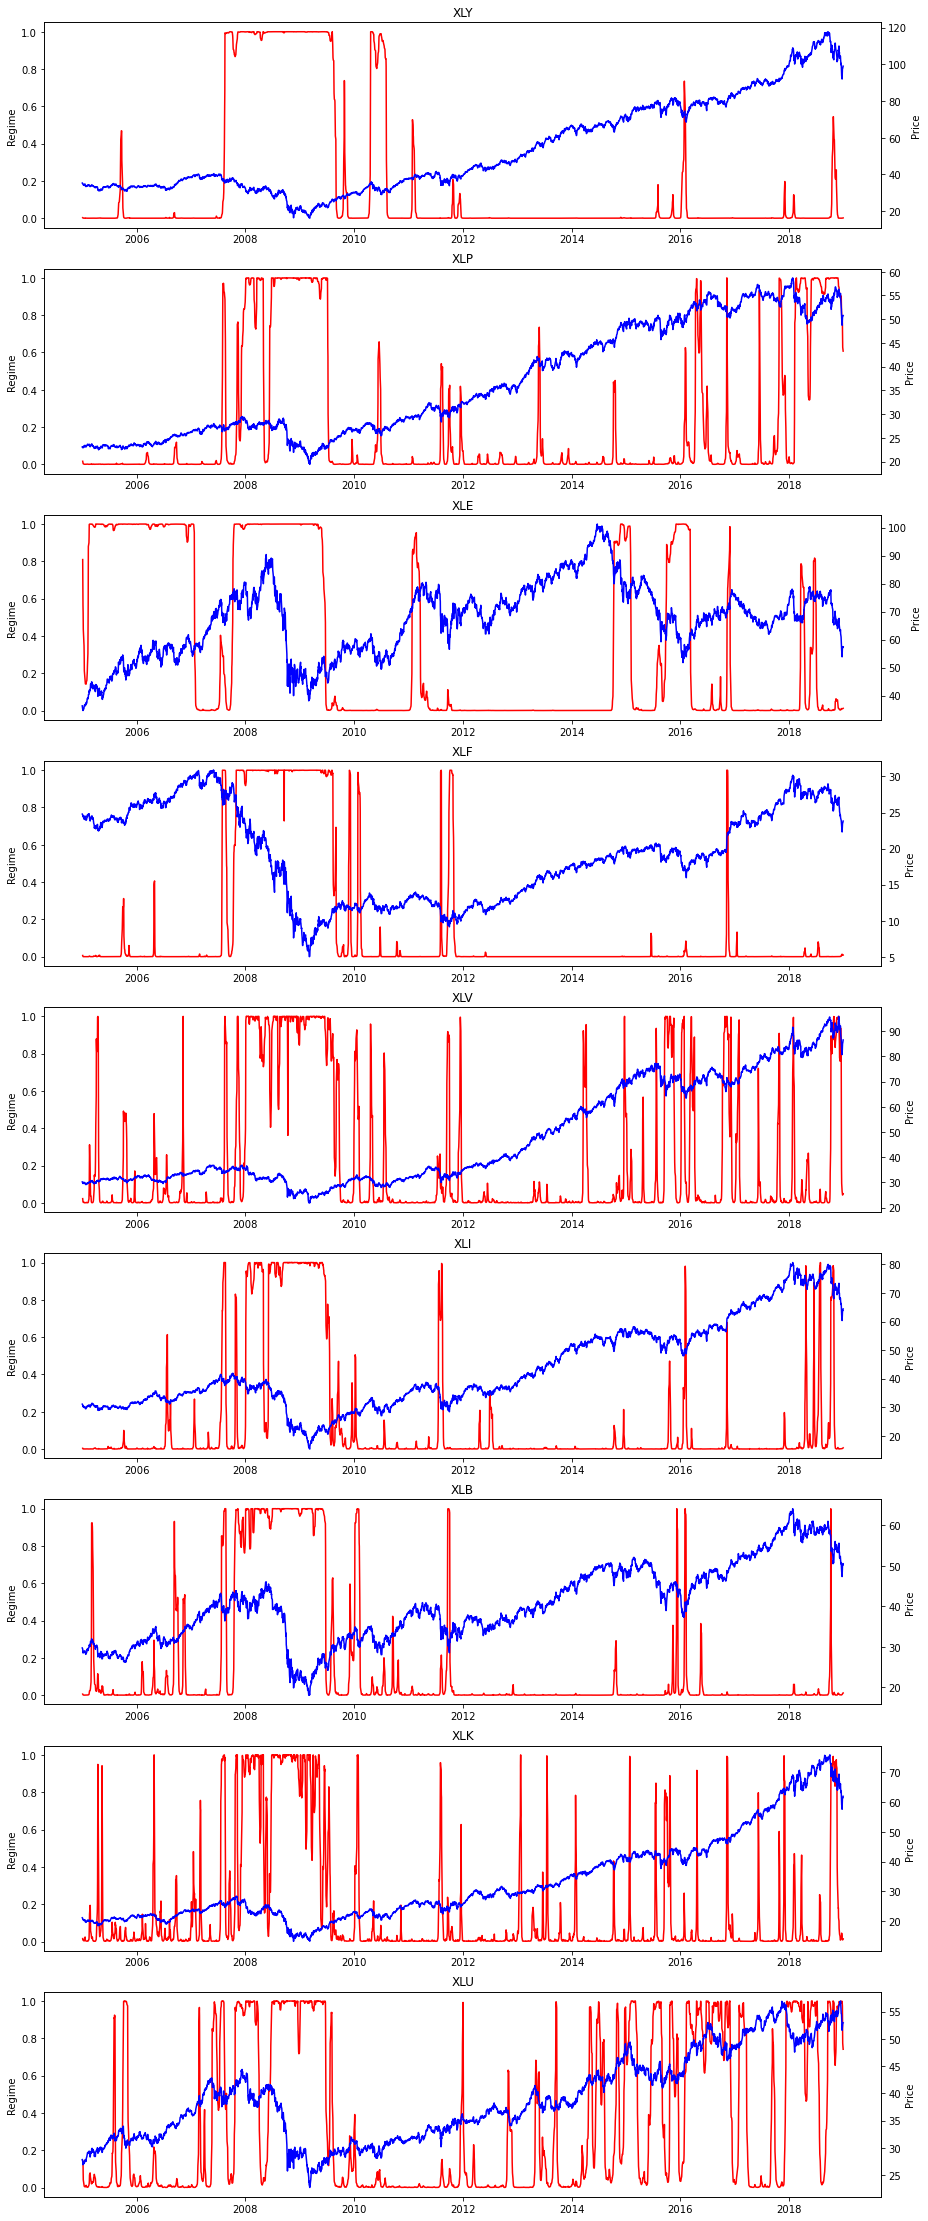

In [22]:
plt.figure(figsize=(20,10))


fig, ax1 = plt.subplots(len(ticker),figsize=(15,40))

for i in range(0,len(ticker)):
    if regimes[i].params['sigma2[0]']>regimes[i].params['sigma2[1]']:
        j=0
    else:
        j=1
    
    ax1[i].plot(regimes[i].smoothed_marginal_probabilities[j], color='red')
    ax2 = ax1[i].twinx()
    ax2.plot(price_data[ticker[i]][:'2018-12-31'], color='blue')
    ax1[i].set_title(ticker[i])
    ax1[i].set_ylabel('Regime')
    ax2.set_ylabel('Price')